# Iridium Jamming Calculations

This notebook is used to generate all the calculations/plots for the Iridium jamming analysis in the paper.

In [2]:
import numpy as np
from scipy import special
import coding
import functools
import os

In [3]:
plot_dir = "../plots"

In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

#palette = 'colorblind'
colors = [
    (190, 15, 52),
    (72, 145, 220),
    (0, 119, 112),
    (207, 122, 48),
    (235, 196, 203),
]
colors_hex = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in colors]

colors_gradient = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in
    [
        (235, 196, 203),
        (190, 15, 52),
        (135, 36, 52)
    ]
]
colors_gradient_str = ','.join(colors_gradient)
palette_gradient = sns.color_palette(f"blend:{colors_gradient_str}", as_cmap=True)

colors_gradient_blue = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in
    [
        (158, 206, 235),
        (72, 145, 220),
        (0, 33, 71),
    ]
]
colors_gradient_str_blue = ','.join(colors_gradient_blue)
palette_gradient_blue = sns.color_palette(f"blend:{colors_gradient_str_blue}", as_cmap=True)

sns.set_theme(palette=colors_hex, color_codes=True)
sns.set_style('ticks')
sns.set_context('notebook')
sns.color_palette(colors_hex)

plt.rcParams['figure.dpi'] = 72

In [5]:
# Decorator to add optional output_pdf and show arguments to plot functions
def plot(func):
    @functools.wraps(func)
    def wrapper(*args, output_pdf=None, dpi=None, show=True, **kwargs):
        res = func(*args, **kwargs)

        if output_pdf is not None:
            if dpi is None:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight')
            else:
                plt.savefig(os.path.join(plot_dir, output_pdf), bbox_inches='tight', dpi=dpi)
        if show:
            plt.show()
        plt.close()

        return res

    return wrapper

In [28]:
# Define standard functions
bers = 10**np.arange(-2, np.log10(5), 0.01)

JSR = np.arange(10**(-18/10), 10**(8/10), 0.01)

bits_per_symbol = 2

EbN0s = (1/ JSR * (1/bits_per_symbol))
BPSK_new = lambda EbN0: 0.5 * special.erfc(np.sqrt(EbN0))
bch_errors = np.vectorize(lambda ber: coding.bch_error_rate(ber, data_length=21, parity_length=10, t=2, interleave_depth=3, symbol_size=2)["equivalent_ber"])
bch_packet_errors = np.vectorize(lambda ber: coding.bch_error_rate(ber, data_length=21, parity_length=10, t=2, interleave_depth=3, symbol_size=2)["packet_error_rate"])

In [31]:
# Plot error correcting potential
@plot
def plot_jammer_power():

    packet_error_rate = lambda p: 1 - ((1-p)**31)**3

    axs = plt.axes()

    xs = 10*np.log10((1/special.erfcinv(2*EbN0s)) * (1/bits_per_symbol))
    JSR_dB = 10*np.log10(JSR)

    axs.plot(JSR_dB, packet_error_rate(BPSK_new(EbN0s)), label="None")
    axs.plot(JSR_dB, bch_packet_errors(BPSK_new(EbN0s)), label="BCH(31, 21, 5)")

    xmin = 10**(-18/10)/2
    xmax = 10**(8/10)/2
    # Find the point where the packet error rate is 0.5
    while xmax - xmin > 0.000001:
        xmid = (xmax + xmin)/2
        if packet_error_rate(BPSK_new((1/xmid) * (1/bits_per_symbol))) > 0.5:
            xmax = xmid
        else:
            xmin = xmid
    # Draw a point
    x_none = 10*np.log10(xmin)

    xmin = 10**(-18/10)/2
    xmax = 10**(8/10)/2
    # Find the point where the packet error rate is 0.5
    while xmax - xmin > 0.000001:
        xmid = (xmax + xmin)/2
        if bch_packet_errors(BPSK_new((1/xmid) * (1/bits_per_symbol))) > 0.5:
            xmax = xmid
        else:
            xmin = xmid
    # Draw a point
    x_bch = 10*np.log10(xmin)
    x_bch = -2.98

    plt.axhline(y=0.5, linestyle="dotted", color="grey")

    axs.plot(x_none, 0.5, marker="o", color=colors_hex[0])
    axs.plot(x_bch, 0.5, marker="o", color=colors_hex[1])

    #axs.plot(10*np.log10(EbN0s)*bits_per_symbol, bch_errors(BPSK(bers)), label="BCH(31, 21, 5) error correction")

    #axs.legend(title="Error correction")
    plt.xlabel('Attacker vs victim power (dB)')
    plt.ylabel('Proportion of invalid messages')

    #plt.ylim(1e-6,1.1)
    #plt.xlim(-20,10)

    # -20,10 x axis
    # data: -18, 8

    xticks_min = -15
    xticks_max = 15
    xticks = np.arange(xticks_min, xticks_max, 5)
    xtick_labels = [f"{x:.0f}" for x in xticks]
    # If draw_crossing, add an x tick at the crossing point
    for x in [x_none, x_bch]:
        xticks = np.append(xticks, x)
        xtick_labels = np.append(xtick_labels, f"{x:.1f}")
    plt.xticks(xticks, xtick_labels)

    plt.legend(loc="lower right", title="Error correction")

    #plt.show()

/tmp/ipykernel_14445/4267449709.py:9: RuntimeWarning: invalid value encountered in log10
  xs = 10*np.log10((1/special.erfcinv(2*EbN0s)) * (1/bits_per_symbol))


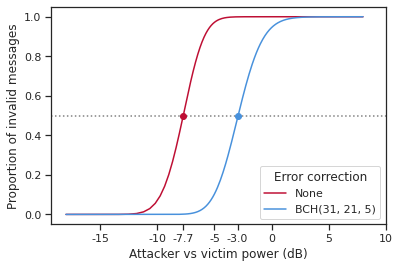

In [32]:
plot_jammer_power(output_pdf="required-jammer-power.pdf")

In [7]:
# Plot error correcting potential
@plot
def plot_jammer_power_2():

    packet_error_rate = lambda p: 1 - ((1-p)**31)**3

    axs = plt.axes()

    xs = 10*np.log10((1/special.erfcinv(2*EbN0s)) * (1/bits_per_symbol))
    JSR_dB = 10*np.log10(JSR)

    axs.plot(JSR_dB, packet_error_rate(BPSK_new(EbN0s)), label="Baseline QPSK, no error correction")
    axs.plot(JSR_dB, bch_packet_errors(BPSK_new(EbN0s)), label="BCH(31, 21, 5) error correction")


    plt.axhline(y=0.5, linestyle="dotted", color="grey")

    axs.legend()
    plt.xlabel('Jammer to signal power ratio [dB]')
    plt.ylabel('Proportion of invalid messages')

    plt.ylim(1e-6,1.1)
    plt.xlim(-20,10)

    # -20,10 x axis
    # data: -18, 8

    plt.legend(loc="lower right")

    #plt.show()

/tmp/ipykernel_14445/3476667627.py:9: RuntimeWarning: invalid value encountered in log10
  xs = 10*np.log10((1/special.erfcinv(2*EbN0s)) * (1/bits_per_symbol))


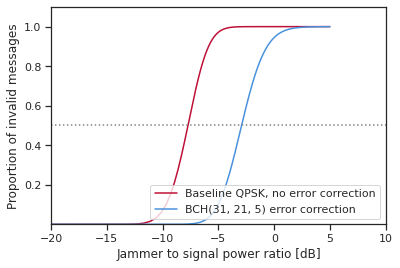

In [8]:
plot_jammer_power_2()

In [19]:
### Plot the distance graph

equipment_1600 = {
    "Module Amp, High Gain Antenna": {
        "output_power": 7,
        "antenna_eirp": 21,
        "frequency": 1600,
    },
    "Custom IC Amp, Patch Antenna": {
        "output_power": 10,
        "antenna_eirp": 0,
        "frequency": 1600,
    },
}

distances = np.array(list(range(1, 400000, 500)))
x_unit = 1000  # km

def fspl(d_m, f_MHz):
    return -1 * (20 * np.log10(d_m) + 20 * np.log10(f_MHz) - 27.55)

def process(equipment):
    results = {}
    for n, x in equipment.items():
        results[n] = list(
            map(
                lambda d: x["output_power"]
                + x["antenna_eirp"]
                + fspl(d, x["frequency"]),
                distances,
            )
        )
    return results
def draw_hatch(ax, y1, y2, name):
    for y in np.linspace(y1, y2, 20, endpoint=False):
        ax.fill_between([0,400], y, y2, alpha=0.02, linewidth=0, rasterized=True)
        ax.fill_between([0,400], y, y2, facecolor="none", hatch="//", alpha=0.04, linewidth=0, rasterized=True)
    # Draw hatches

    ax.hlines(
        [y2],
        0,
        400,
        linestyle="dashed",
        #color=colcycle[color + 4],
        label=name,
    )

@plot
def plot_distance_graph():
    axs = plt.axes()

    for n, res in process(equipment_1600).items():
        axs.plot(distances / x_unit, res, label=n)
    axs.plot([np.NaN], linestyle="-", color="black", alpha=0.0, label=" ")
    draw_hatch(axs, -145 - (2.98 + 7), -145 -2.98, "Power to Jam 50% Ring Alerts")
    axs.legend()
    axs.margins(x=0)

    plt.ylabel("Attacker received power (dBW)")
    plt.xlabel("Attacker distance from victim receiver (km)")

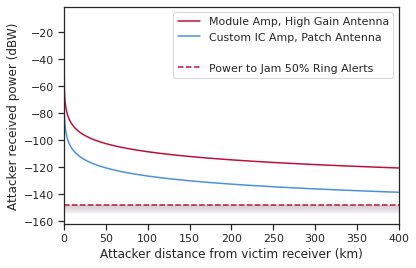

In [20]:
plot_distance_graph(output_pdf="equipment_path_loss.pdf")